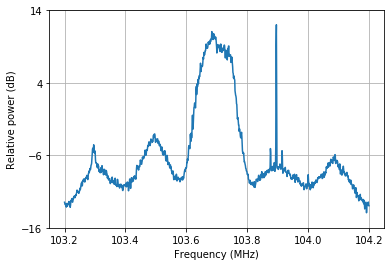

In [2]:
from pylab import *
from rtlsdr import *
#matplotlib inline
sdr = RtlSdr()

# configure device
sdr.sample_rate = 1e6
sdr.center_freq = 103.7e6
sdr.gain = 4

samples = sdr.read_samples(256*1024)
sdr.close()

# use matplotlib to estimate and plot the PSD
psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
xlabel('Frequency (MHz)')
ylabel('Relative power (dB)')

show()

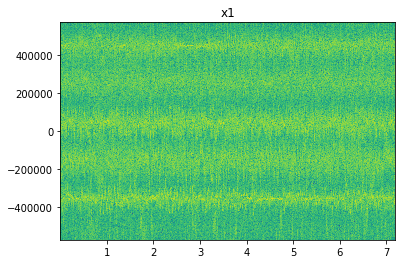

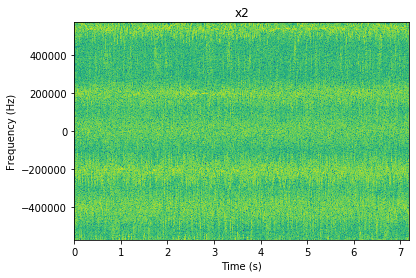

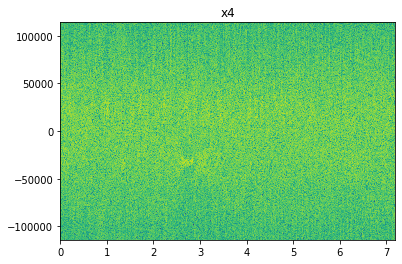

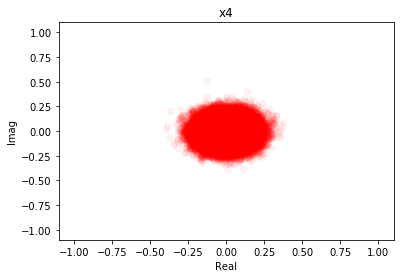

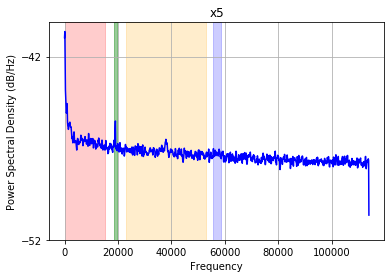

45600.0


In [3]:
from rtlsdr import RtlSdr  
import numpy as np  
import scipy.signal as signal

import matplotlib  
#matplotlib.use('Agg') # necessary for headless mode  
# see http://stackoverflow.com/a/3054314/3524528

import matplotlib.pyplot as plt


sdr = RtlSdr()

F_station = int(94.1e6)  # Pick a radio station  
F_offset = 250000         # Offset to capture at  
# We capture at an offset to avoid DC spike
Fc = F_station - F_offset # Capture center frequency  
Fs = int(1140000)         # Sample rate  
N = int(8192000)            # Samples to capture  

# configure device
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'

# Read samples
samples = sdr.read_samples(N)

# Clean up the SDR device
sdr.close()  
del(sdr)

# Convert samples to a numpy array
x1 = np.array(samples).astype("complex64")

plt.specgram(x1, NFFT=2048, Fs=Fs)  
plt.title("x1")  
plt.ylim(-Fs/2, Fs/2)  
#plt.plot("x1_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()

# To mix the data down, generate a digital complex exponential 
# (with the same length as x1) with phase -F_offset/Fs
fc1 = np.exp(-1.0j*2.0*np.pi* F_offset/Fs*np.arange(len(x1)))  
# Now, just multiply x1 and the digital complex expontential
x2 = x1 * fc1  

plt.specgram(x2, NFFT=2048, Fs=Fs)  
plt.title("x2")  
plt.xlabel("Time (s)")  
plt.ylabel("Frequency (Hz)")  
plt.ylim(-Fs/2, Fs/2)  
plt.xlim(0,len(x2)/Fs)  
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x2_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 200000  
n_taps = 64  
# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(Fs/2-f_bw)/4, Fs/2], [1,0], Hz=Fs)  
x3 = signal.lfilter(lpf, 1.0, x2)

dec_rate = int(Fs / f_bw)  
x4 = x3[0::dec_rate]  
# Calculate the new sampling rate
Fs_y = Fs/dec_rate  


plt.specgram(x4, NFFT=2048, Fs=Fs_y)  
plt.title("x4")  
plt.ylim(-Fs_y/2, Fs_y/2)  
plt.xlim(0,len(x4)/Fs_y)  
plt.ticklabel_format(style='plain', axis='y' )  

#plt.plot("x4_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

# Plot the constellation of x4.  What does it look like?
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)  
plt.title("x4")  
plt.xlabel("Real")  
plt.xlim(-1.1,1.1)  
plt.ylabel("Imag")  
plt.ylim(-1.1,1.1)  
#plt.plot("x4_const.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

### Polar discriminator
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)  

# Note: x5 is now an array of real, not complex, values
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  


# The de-emphasis filter
# Given a signal 'x5' (in a numpy array) with sampling rate Fs_y
d = Fs_y * 75e-6   # Calculate the # of samples to hit the -3dB point  
x = np.exp(-1/d)   # Calculate the decay between each sample  
b = [1-x]          # Create the filter coefficients  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)  

# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq = 44100.0  
dec_audio = int(Fs_y/audio_freq)  
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)  

# Scale audio to adjust volume
x7 *= 10000 / np.max(np.abs(x7))  
# Save to file as 16-bit signed single-channel audio samples
x7.astype("int16").tofile("wbfm-mono.raw")  

print(Fs_audio)

In [5]:
from rtlsdr import RtlSdr  

import numpy as np  
import scipy.signal as signal

import matplotlib  
matplotlib.use('Agg') # necessary for headless mode  
# see http://stackoverflow.com/a/3054314/3524528
import matplotlib.pyplot as plt


sdr = RtlSdr()

F_station = int(97.3e6)  # Pick a radio station  
F_offset = 250000         # Offset to capture at  
# We capture at an offset to avoid DC spike
Fc = F_station - F_offset # Capture center frequency  
Fs = int(1140000)         # Sample rate  
N = int(8192000)            # Samples to capture  

# configure device
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'

# Read samples
samples = sdr.read_samples(N)

# Clean up the SDR device
sdr.close()  
del(sdr)

# Convert samples to a numpy array
x1 = np.array(samples).astype("complex64")

plt.specgram(x1, NFFT=2048, Fs=Fs)  
plt.title("x1")  
plt.ylim(-Fs/2, Fs/2)  
plt.savefig("x1_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.close()

# To mix the data down, generate a digital complex exponential 
# (with the same length as x1) with phase -F_offset/Fs
fc1 = np.exp(-1.0j*2.0*np.pi* F_offset/Fs*np.arange(len(x1)))  
# Now, just multiply x1 and the digital complex expontential
x2 = x1 * fc1  

plt.specgram(x2, NFFT=2048, Fs=Fs)  
plt.title("x2")  
plt.xlabel("Time (s)")  
plt.ylabel("Frequency (Hz)")  
plt.ylim(-Fs/2, Fs/2)  
plt.xlim(0,len(x2)/Fs)  
plt.ticklabel_format(style='plain', axis='y' )  
#plt.savefig("x2_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 200000  
n_taps = 64  
# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(Fs/2-f_bw)/4, Fs/2], [1,0], Hz=Fs)  
x3 = signal.lfilter(lpf, 1.0, x2)

dec_rate = int(Fs / f_bw)  
x4 = x3[0::dec_rate]  
# Calculate the new sampling rate
Fs_y = Fs/dec_rate  


plt.specgram(x4, NFFT=2048, Fs=Fs_y)  
plt.title("x4")  
plt.ylim(-Fs_y/2, Fs_y/2)  
plt.xlim(0,len(x4)/Fs_y)  
plt.ticklabel_format(style='plain', axis='y' )  

#plt.savefig("x4_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

# Plot the constellation of x4.  What does it look like?
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)  
plt.title("x4")  
plt.xlabel("Real")  
plt.xlim(-1.1,1.1)  
plt.ylabel("Imag")  
plt.ylim(-1.1,1.1)  
#plt.savefig("x4_const.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

### Polar discriminator
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)  

# Note: x5 is now an array of real, not complex, values
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
#plt.savefig("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  


# The de-emphasis filter
# Given a signal 'x5' (in a numpy array) with sampling rate Fs_y
d = Fs_y * 75e-6   # Calculate the # of samples to hit the -3dB point  
x = np.exp(-1/d)   # Calculate the decay between each sample  
b = [1-x]          # Create the filter coefficients  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)  

# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq = 44100.0  
dec_audio = int(Fs_y/audio_freq)  
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)  

# Scale audio to adjust volume
x7 *= 10000 / np.max(np.abs(x7))  
# Save to file as 16-bit signed single-channel audio samples
#x7.astype("int16").tofile("wbfm-mono.raw")  



/home/aalmela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/home/aalmela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/home/aalmela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/home/aalmela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
